# Assignment2

Imports

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
import seaborn as sns

Import the data

In [2]:
df = pd.read_csv(r"athletes.csv")

/var/folders/lt/x1xcmh9n5xz2fgqn5y9_3kf40000gn/T/ipykernel_55870/3087902215.py:1: DtypeWarning: Columns (27) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(r"athletes.csv")


Remove rows with more than 1 NaN and columns NaNs

In [3]:
df=df.dropna(thresh=27)
df = df.dropna(axis=1, thresh=len(df))

Display

In [4]:
display(df)

,athlete_id,name,region,gender,age,deadlift,train
102,2720.0,Justin Adams,South Central,Male,24.0,475.0,I workout mostly at a CrossFit Affiliate|I hav...
110,6922.0,Daniel Adamson,South West,Male,31.0,410.0,I workout mostly at a CrossFit Affiliate|I inc...
116,12563.0,Steven Lee Adams,Mid Atlantic,Male,37.0,525.0,I workout mostly at a CrossFit Affiliate|I inc...
238,24943.0,Greg Adler,Mid Atlantic,Male,44.0,405.0,I workout mostly at a CrossFit Affiliate|I hav...
304,3066.0,Luke Ahlfield,North Central,Male,31.0,455.0,I workout mostly at a CrossFit Affiliate|I inc...
...,...,...,...,...,...,...,...
375133,103943.0,Robert Payton,South East,Male,56.0,295.0,I workout mostly at a CrossFit Affiliate|I wri...
380392,4932.0,Troy Straith,Canada West,Male,54.0,345.0,I workout mostly at a CrossFit Affiliate|I hav...
382760,110296.0,Dennis Walczyk,South West,Male,36.0,440.0,"I workout mostly at home, work, or a tradition..."
396717,6878.0,Jessica McCain,North Central,Female,26.0,355.0,I workout mostly at a CrossFit Affiliate|I hav...


## 3.1 Anonymisation: Bare Bones

Text(0.5, 1.0, 'Cardinality')

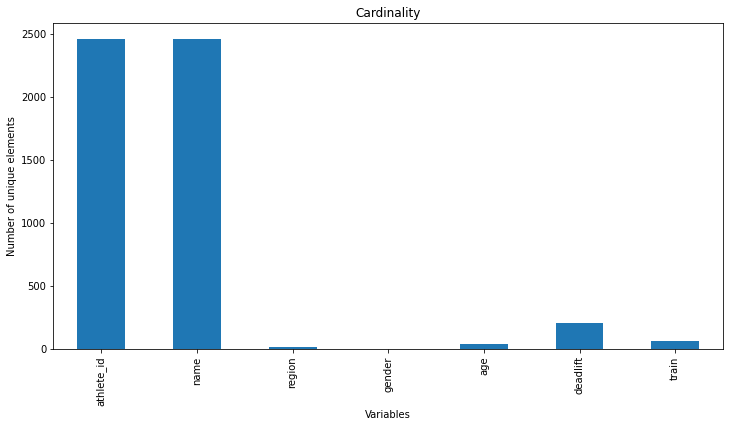

In [5]:
df.nunique().plot.bar(figsize=(12,6))
plt.ylabel('Number of unique elements')
plt.xlabel('Variables')
plt.title('Cardinality')

Quassi Idetifiers Combination values uniqueness

In [6]:
display(df.groupby(['age','region','gender']).size().reset_index(name='count'))

,age,region,gender,count
0,14.0,South Central,Male,1
1,17.0,Australia,Male,1
2,17.0,North Central,Male,1
3,17.0,North East,Male,1
4,17.0,North West,Male,1
...,...,...,...,...
740,55.0,South West,Male,1
741,56.0,Canada West,Male,1
742,56.0,Central East,Male,1
743,56.0,South East,Male,1


In [7]:
def k_anonymity(data, k, suppression_order):
    anonymized_data = data.copy()

    for column in suppression_order:
        # Group by quasi-identifiers and count records in each group
        grouped_data = anonymized_data.groupby(['region', 'age', 'gender']).size().reset_index(name='count')

        # Identify groups that don't meet k-anonymity and suppress values selectively if needed
        for index, row in grouped_data.iterrows():
            if row['count'] < k:
                if grouped_data[column].nunique() > 1:
                    # Create a mask for the specific column based on quasi-identifier values
                    mask = (anonymized_data['region'] == row['region']) & \
                        (anonymized_data['age'] == row['age']) & \
                        (anonymized_data['gender'] == row['gender'])
                    # Apply the '*' suppression to the specific column where the row matches
                    anonymized_data.loc[mask, column] = '*'

    return anonymized_data

suppression_order = ['age', 'gender', 'region']

anonymized_data = k_anonymity(df, k=5, suppression_order=suppression_order)

display(anonymized_data.groupby(['region', 'age', 'gender']).size().reset_index(name='count'))
print("Anonymized:")
display(anonymized_data)

,region,age,gender,count
0,*,*,*,6
1,Africa,*,Female,5
2,Africa,*,Male,15
3,Asia,*,Male,22
4,Australia,23.0,Male,6
...,...,...,...,...
213,Southern California,35.0,Male,6
214,Southern California,36.0,Male,9
215,Southern California,37.0,Male,6
216,Southern California,*,Female,43


Anonymized:


,athlete_id,name,region,gender,age,deadlift,train
102,2720.0,Justin Adams,South Central,Male,24.0,475.0,I workout mostly at a CrossFit Affiliate|I hav...
110,6922.0,Daniel Adamson,South West,Male,31.0,410.0,I workout mostly at a CrossFit Affiliate|I inc...
116,12563.0,Steven Lee Adams,Mid Atlantic,Male,37.0,525.0,I workout mostly at a CrossFit Affiliate|I inc...
238,24943.0,Greg Adler,Mid Atlantic,Male,*,405.0,I workout mostly at a CrossFit Affiliate|I hav...
304,3066.0,Luke Ahlfield,North Central,Male,31.0,455.0,I workout mostly at a CrossFit Affiliate|I inc...
...,...,...,...,...,...,...,...
375133,103943.0,Robert Payton,South East,Male,*,295.0,I workout mostly at a CrossFit Affiliate|I wri...
380392,4932.0,Troy Straith,Canada West,Male,*,345.0,I workout mostly at a CrossFit Affiliate|I hav...
382760,110296.0,Dennis Walczyk,South West,Male,*,440.0,"I workout mostly at home, work, or a tradition..."
396717,6878.0,Jessica McCain,North Central,Female,*,355.0,I workout mostly at a CrossFit Affiliate|I hav...


## 3.1 and 3.2 Anonymising your dataset

### Approach 1 Generalize and do k-anonymity

In [8]:
def k_anonymity_generalization(data, k, quassi_identifiers):
    anonymized_data = data.copy()

    #generalize
    anonymized_data['age'] =  pd.cut(anonymized_data['age'],bins=k)
    anonymized_data['age'] = anonymized_data['age'].cat.add_categories('*')
    
    for column in quassi_identifiers:
        grouped_data = anonymized_data.groupby(['region', 'age', 'gender']).size().reset_index(name='count')

        groups_to_anonymize = grouped_data[grouped_data['count'] < k][['region', 'age', 'gender']]

        for index, row in groups_to_anonymize.iterrows():
            mask = (anonymized_data['region'] == row['region']) & \
                   (anonymized_data['age'] == row['age']) & \
                   (anonymized_data['gender'] == row['gender'])

            if mask.any():
                if len(anonymized_data[mask]) < k:
                        anonymized_data.loc[mask, column] = '*'

    return anonymized_data


quassi_identifiers = ['age', 'gender', 'region']

k_anonymized_generalization = k_anonymity_generalization(df, k=5, quassi_identifiers=quassi_identifiers)


counts=k_anonymized_generalization.groupby(['region', 'age', 'gender']).size().reset_index(name='count')
print("Anonymized:")
display(counts[counts['count']>0])

Anonymized:


,region,age,gender,count
15,*,*,*,18
23,Africa,"(22.4, 30.8]",Male,9
34,Africa,*,Female,5
35,Africa,*,Male,6
41,Asia,"(22.4, 30.8]",Male,9
...,...,...,...,...
314,Southern California,"(30.8, 39.2]",Male,55
316,Southern California,"(39.2, 47.6]",Female,7
317,Southern California,"(39.2, 47.6]",Male,17
320,Southern California,"(47.6, 56.0]",Male,8


### Approach 2 Perturbation

In [9]:
def k_anonymity_perturbation(data, k, quassi_identifiers):
    anonymized_data = data.copy()
    
    
    #Perturbation
    np.random.seed(42)
    noise = np.random.uniform(-3, 3, size=len(data))
    anonymized_data['age'] = data['age'] + np.round(noise)

    

    for column in quassi_identifiers:
        grouped_data = anonymized_data.groupby(['region', 'age', 'gender']).size().reset_index(name='count')

        groups_to_anonymize = grouped_data[grouped_data['count'] < k][['region', 'age', 'gender']]

        for index, row in groups_to_anonymize.iterrows():
            mask = (anonymized_data['region'] == row['region']) & \
                   (anonymized_data['age'] == row['age']) & \
                   (anonymized_data['gender'] == row['gender'])

            if mask.any():
                if len(anonymized_data[mask]) < k:
                        anonymized_data.loc[mask, column] = '*'

    return anonymized_data


quassi_identifiers = ['age', 'gender', 'region']

k_anonymized_perturbation = k_anonymity_perturbation(df, k=5, quassi_identifiers=quassi_identifiers)


display(k_anonymized_perturbation.groupby(['region', 'age', 'gender']).size().reset_index(name='count'))
display(df)
print("Anonymized:")
display(k_anonymized_perturbation)

,region,age,gender,count
0,*,*,*,6
1,Africa,*,Female,5
2,Africa,*,Male,15
3,Asia,32.0,Male,5
4,Asia,*,Male,17
...,...,...,...,...
218,Southern California,36.0,Male,11
219,Southern California,37.0,Male,6
220,Southern California,38.0,Male,6
221,Southern California,*,Female,34


,athlete_id,name,region,gender,age,deadlift,train
102,2720.0,Justin Adams,South Central,Male,24.0,475.0,I workout mostly at a CrossFit Affiliate|I hav...
110,6922.0,Daniel Adamson,South West,Male,31.0,410.0,I workout mostly at a CrossFit Affiliate|I inc...
116,12563.0,Steven Lee Adams,Mid Atlantic,Male,37.0,525.0,I workout mostly at a CrossFit Affiliate|I inc...
238,24943.0,Greg Adler,Mid Atlantic,Male,44.0,405.0,I workout mostly at a CrossFit Affiliate|I hav...
304,3066.0,Luke Ahlfield,North Central,Male,31.0,455.0,I workout mostly at a CrossFit Affiliate|I inc...
...,...,...,...,...,...,...,...
375133,103943.0,Robert Payton,South East,Male,56.0,295.0,I workout mostly at a CrossFit Affiliate|I wri...
380392,4932.0,Troy Straith,Canada West,Male,54.0,345.0,I workout mostly at a CrossFit Affiliate|I hav...
382760,110296.0,Dennis Walczyk,South West,Male,36.0,440.0,"I workout mostly at home, work, or a tradition..."
396717,6878.0,Jessica McCain,North Central,Female,26.0,355.0,I workout mostly at a CrossFit Affiliate|I hav...


Anonymized:


,athlete_id,name,region,gender,age,deadlift,train
102,2720.0,Justin Adams,South Central,Male,23.0,475.0,I workout mostly at a CrossFit Affiliate|I hav...
110,6922.0,Daniel Adamson,South West,Male,*,410.0,I workout mostly at a CrossFit Affiliate|I inc...
116,12563.0,Steven Lee Adams,Mid Atlantic,Male,38.0,525.0,I workout mostly at a CrossFit Affiliate|I inc...
238,24943.0,Greg Adler,Mid Atlantic,Male,*,405.0,I workout mostly at a CrossFit Affiliate|I hav...
304,3066.0,Luke Ahlfield,North Central,Male,29.0,455.0,I workout mostly at a CrossFit Affiliate|I inc...
...,...,...,...,...,...,...,...
375133,103943.0,Robert Payton,South East,Male,*,295.0,I workout mostly at a CrossFit Affiliate|I wri...
380392,4932.0,Troy Straith,Canada West,Male,*,345.0,I workout mostly at a CrossFit Affiliate|I hav...
382760,110296.0,Dennis Walczyk,South West,Male,35.0,440.0,"I workout mostly at home, work, or a tradition..."
396717,6878.0,Jessica McCain,North Central,Female,29.0,355.0,I workout mostly at a CrossFit Affiliate|I hav...


### Just in case added an additional approach
### Approach 3 permutation (Swap records or attribute values to „force“ clustering) 

In [10]:
def k_anonymity_permutation(data, k, quassi_identifiers):
    anonymized_data = data.copy()

    np.random.seed(42)  
    anonymized_data = data.copy()
    grouped_data = anonymized_data.groupby(['region', 'gender'])

    for name, group in grouped_data:
        permuted_age = np.random.permutation(group['age'].values)
        anonymized_data.loc[group.index, 'age'] = permuted_age 

    for column in quassi_identifiers:
        grouped_data = anonymized_data.groupby(['region', 'age', 'gender']).size().reset_index(name='count')

        groups_to_anonymize = grouped_data[grouped_data['count'] < k][['region', 'age', 'gender']]

        for index, row in groups_to_anonymize.iterrows():
            mask = (anonymized_data['region'] == row['region']) & \
                   (anonymized_data['age'] == row['age']) & \
                   (anonymized_data['gender'] == row['gender'])

            if mask.any():
                if len(anonymized_data[mask]) < k:
                        anonymized_data.loc[mask, column] = '*'

    return anonymized_data


quassi_identifiers = ['age', 'gender', 'region']

k_anonymized_permutation = k_anonymity_permutation(df, k=5, quassi_identifiers=quassi_identifiers)


display(k_anonymized_permutation.groupby(['region', 'age', 'gender']).size().reset_index(name='count'))
print("Anonymized:")
display(k_anonymized_permutation)

,region,age,gender,count
0,*,*,*,6
1,Africa,*,Female,5
2,Africa,*,Male,15
3,Asia,*,Male,22
4,Australia,23.0,Male,6
...,...,...,...,...
213,Southern California,35.0,Male,6
214,Southern California,36.0,Male,9
215,Southern California,37.0,Male,6
216,Southern California,*,Female,43


Anonymized:


,athlete_id,name,region,gender,age,deadlift,train
102,2720.0,Justin Adams,South Central,Male,*,475.0,I workout mostly at a CrossFit Affiliate|I hav...
110,6922.0,Daniel Adamson,South West,Male,*,410.0,I workout mostly at a CrossFit Affiliate|I inc...
116,12563.0,Steven Lee Adams,Mid Atlantic,Male,28.0,525.0,I workout mostly at a CrossFit Affiliate|I inc...
238,24943.0,Greg Adler,Mid Atlantic,Male,29.0,405.0,I workout mostly at a CrossFit Affiliate|I hav...
304,3066.0,Luke Ahlfield,North Central,Male,34.0,455.0,I workout mostly at a CrossFit Affiliate|I inc...
...,...,...,...,...,...,...,...
375133,103943.0,Robert Payton,South East,Male,47.0,295.0,I workout mostly at a CrossFit Affiliate|I wri...
380392,4932.0,Troy Straith,Canada West,Male,*,345.0,I workout mostly at a CrossFit Affiliate|I hav...
382760,110296.0,Dennis Walczyk,South West,Male,28.0,440.0,"I workout mostly at home, work, or a tradition..."
396717,6878.0,Jessica McCain,North Central,Female,28.0,355.0,I workout mostly at a CrossFit Affiliate|I hav...


## 3.3 Compartmentation and Clustering

In [11]:
def similarity_for_quassi_identifiers(dataset, quasi_identifiers):
    subset = dataset[quasi_identifiers].copy()

    for column in quasi_identifiers:
        if dataset[column].dtype == 'O': 
            subset = pd.concat([subset, pd.get_dummies(dataset[column], prefix=column)], axis=1)
     
    subset.drop('gender', axis=1, inplace=True) 
    subset.drop('region', axis=1, inplace=True)   

    similarity_matrix = subset.dot(subset.T) / (np.linalg.norm(subset, axis=1)[:, None] * np.linalg.norm(subset, axis=1))
    
    return similarity_matrix

def clustering(similarity_matrix, k):
    kmeans = KMeans(n_clusters=k, random_state=42)
    clusters = kmeans.fit_predict(similarity_matrix)
    return clusters

def anonymize_clusters(dataset, clusters, quasi_identifiers):
    anonymized_dataset = dataset.copy()

    anonymized_dataset['Cluster'] = clusters

    for cluster_id in np.unique(clusters):
        cluster_mask = (anonymized_dataset['Cluster'] == cluster_id)

        common_values = anonymized_dataset.loc[cluster_mask, quasi_identifiers].mode().iloc[0]
    
        age_min = anonymized_dataset.loc[cluster_mask, 'age'].min()
        age_max = anonymized_dataset.loc[cluster_mask, 'age'].max()
        common_values['age'] = f"{age_min}-{age_max}"

        anonymized_dataset.loc[cluster_mask, 'age'] = common_values['age']
        anonymized_dataset.loc[cluster_mask, 'gender'] = common_values['gender']
        anonymized_dataset.loc[cluster_mask, 'region'] = common_values['region']

    anonymized_dataset.drop('Cluster', axis=1, inplace=True)

    return anonymized_dataset

quasi_identifiers = ['age', 'gender', 'region']
similarity_matrix = similarity_for_quassi_identifiers(df, quasi_identifiers)
clusters = clustering(similarity_matrix, k=6)
anonymized_df = anonymize_clusters(df, clusters, quasi_identifiers)

print("Original Dataset:")
display(df)

print("Anonymized Dataset:")
display(anonymized_df)


Original Dataset:


,athlete_id,name,region,gender,age,deadlift,train
102,2720.0,Justin Adams,South Central,Male,24.0,475.0,I workout mostly at a CrossFit Affiliate|I hav...
110,6922.0,Daniel Adamson,South West,Male,31.0,410.0,I workout mostly at a CrossFit Affiliate|I inc...
116,12563.0,Steven Lee Adams,Mid Atlantic,Male,37.0,525.0,I workout mostly at a CrossFit Affiliate|I inc...
238,24943.0,Greg Adler,Mid Atlantic,Male,44.0,405.0,I workout mostly at a CrossFit Affiliate|I hav...
304,3066.0,Luke Ahlfield,North Central,Male,31.0,455.0,I workout mostly at a CrossFit Affiliate|I inc...
...,...,...,...,...,...,...,...
375133,103943.0,Robert Payton,South East,Male,56.0,295.0,I workout mostly at a CrossFit Affiliate|I wri...
380392,4932.0,Troy Straith,Canada West,Male,54.0,345.0,I workout mostly at a CrossFit Affiliate|I hav...
382760,110296.0,Dennis Walczyk,South West,Male,36.0,440.0,"I workout mostly at home, work, or a tradition..."
396717,6878.0,Jessica McCain,North Central,Female,26.0,355.0,I workout mostly at a CrossFit Affiliate|I hav...


Anonymized Dataset:


,athlete_id,name,region,gender,age,deadlift,train
102,2720.0,Justin Adams,South Central,Male,22.0-27.0,475.0,I workout mostly at a CrossFit Affiliate|I hav...
110,6922.0,Daniel Adamson,North East,Male,27.0-35.0,410.0,I workout mostly at a CrossFit Affiliate|I inc...
116,12563.0,Steven Lee Adams,South East,Male,32.0-56.0,525.0,I workout mostly at a CrossFit Affiliate|I inc...
238,24943.0,Greg Adler,South East,Male,32.0-56.0,405.0,I workout mostly at a CrossFit Affiliate|I hav...
304,3066.0,Luke Ahlfield,North East,Male,27.0-35.0,455.0,I workout mostly at a CrossFit Affiliate|I inc...
...,...,...,...,...,...,...,...
375133,103943.0,Robert Payton,South East,Male,32.0-56.0,295.0,I workout mostly at a CrossFit Affiliate|I wri...
380392,4932.0,Troy Straith,South East,Male,32.0-56.0,345.0,I workout mostly at a CrossFit Affiliate|I hav...
382760,110296.0,Dennis Walczyk,South East,Male,32.0-56.0,440.0,"I workout mostly at home, work, or a tradition..."
396717,6878.0,Jessica McCain,North Central,Female,18.0-30.0,355.0,I workout mostly at a CrossFit Affiliate|I hav...


## 3.4 Testing Data Utility

### 1

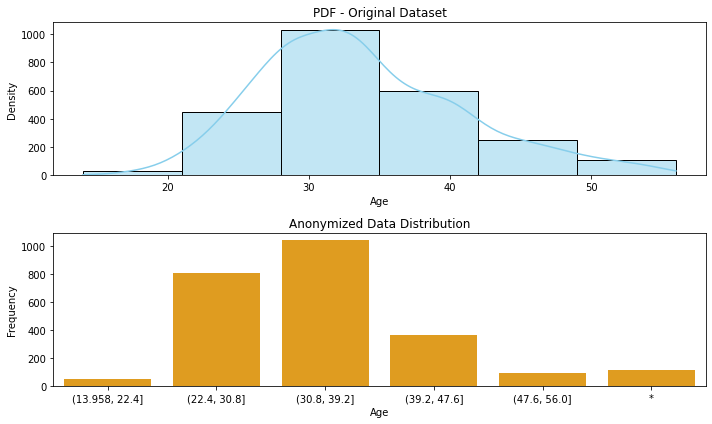

In [27]:
plt.figure(figsize=(10, 6))

plt.subplot(2, 1, 1)
sns.histplot(df['age'], kde=True, color='skyblue', bins=6)
plt.title('PDF - Original Dataset')
plt.xlabel('Age')
plt.ylabel('Density')

plt.subplot(2, 1, 2)
sns.countplot(data=k_anonymized_generalization, x='age', color='orange')
plt.title('Anonymized Data Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

102       22.0-27.0
110       27.0-35.0
116       32.0-56.0
238       32.0-56.0
304       27.0-35.0
            ...    
375133    32.0-56.0
380392    32.0-56.0
382760    32.0-56.0
396717    18.0-30.0
421423    29.0-55.0
Name: age, Length: 2462, dtype: category
Categories (6, object): ['14.0-22.0' < '18.0-30.0' < '22.0-27.0' < '27.0-35.0' < '29.0-55.0' < '32.0-56.0']


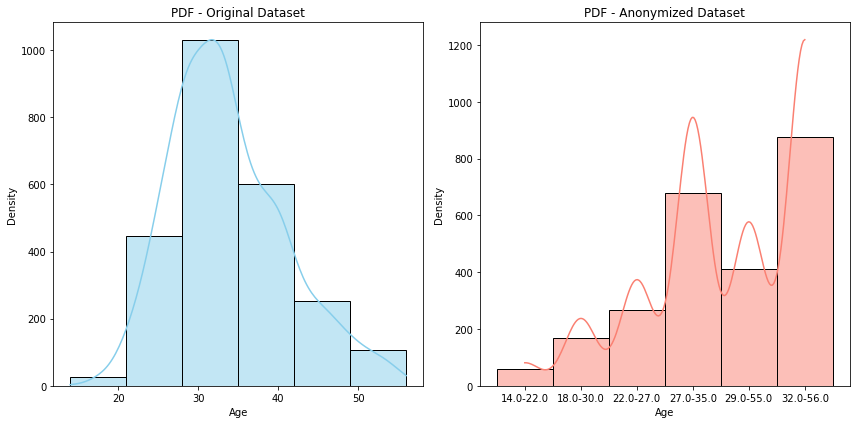

In [29]:
custom_order = sorted(anonymized_df['age'].unique())
anonymized_df['age'] = pd.Categorical(anonymized_df['age'], categories=custom_order, ordered=True)
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(df['age'], kde=True, color='skyblue', bins=6)
plt.title('PDF - Original Dataset')
plt.xlabel('Age')
plt.ylabel('Density')

plt.subplot(1, 2, 2)
sns.histplot(anonymized_df['age'], kde=True, color='salmon', bins=custom_order, discrete=True)
plt.title('PDF - Anonymized Dataset')
plt.xlabel('Age')
plt.ylabel('Density')

plt.tight_layout()
plt.show()